# Wav2Letter Example using Google Speech Command Dataset

Google Speech Command Dataset can be found [here](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data). This dataset was chosen as a quick and convenient way to test Wav2Letter performance

In [1]:
## basic packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from importlib import reload
from tqdm.notebook import tqdm

## Load Data

In [2]:
import Module.dataloading
reload(Module.dataloading)
from Module.dataloading import GoogleSpeechCommand, get_loaders

labels = ['right', 'eight', 'cat', 'tree', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'nine', 'left',
          'stop', 'three', 'sheila', 'one', 'bird', 'zero','seven', 'up', 'marvin', 'two', 'house',
          'down', 'six', 'yes', 'on', 'five', 'off', 'four']

alphabet = 'qwertyuiopasdfghjklzxcvbnm'

# using google's speech command dataset
dataset = GoogleSpeechCommand(labels=labels, alphabet=alphabet, max_frame_len=250, data_path="/home/labmanager/Documents/DataSet/ASR/GSC/google/", preprocess='mfcc')
print('total samples:',len(dataset))
train_loader, val_loader, test_loader, splits = get_loaders(dataset, batch_size=10, splits=[0.7, 0.1, 0.2])
print('splits:', splits)
print(dataset.intencode.grapheme_count)

total samples: 64721
splits: [45304, 6472, 12945]
28


In [3]:
x,y = dataset[0]
print(x.shape)

(40, 250)


## Build Model

In [5]:
import Module.model
reload(Module.model)
from Module.model import Wav2Letter

num_features = 40
num_classes = dataset.intencode.grapheme_count
criterion = nn.CTCLoss()
device = torch.device('cuda:0')

model = Wav2Letter(num_features, num_classes, criterion, device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)

Wav2Letter(
  (criterion): CTCLoss()
  (layers): Sequential(
    (0): Conv1d(40, 250, kernel_size=(31,), stride=(2,))
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(250, 250, kernel_size=(19,), stride=(1,))
    (4): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(250, 250, kernel_size=(17,), stride=(1,))
    (7): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(250, 250, kernel_size=(11,), stride=(1,))
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(250, 250, kernel_size=(7,), stride=(1,))
    (13): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): ReLU()
    (15): Conv1d(250, 250, kernel_size=(7,), stride=(1,))
    (16): BatchNorm1d(250, eps=1e-05, momentum=0.1, a

In [6]:
model.get_n_params()

5639528

In [6]:
# model.load('wav2letter_1.pkl')

## Train

In [7]:
model.fit(train_loader, val_loader=val_loader, epochs=10, optimizer=optimizer, verbose=1)

epoch 1  loss : 0.1920410399589146 val loss : 0.17871451390762116
epoch 2  loss : 0.18203972176877767 val loss : 0.17969050946356488
epoch 3  loss : 0.1729149349650877 val loss : 0.17353780037172056
epoch 4  loss : 0.17583881994818243 val loss : 0.18196767568588257
epoch 5  loss : 0.17508877307287105 val loss : 0.16649062784183746
epoch 6  loss : 0.16100615539273755 val loss : 0.15908104722815183
epoch 7  loss : 0.1554603450646275 val loss : 0.15772253223343743
epoch 8  loss : 0.15948467588263646 val loss : 0.1559779870753235
epoch 9  loss : 0.14856014931326134 val loss : 0.17608740767383457
epoch 10  loss : 0.14804141418937658 val loss : 0.14506512007253575



In [8]:
model.save('mfcc')

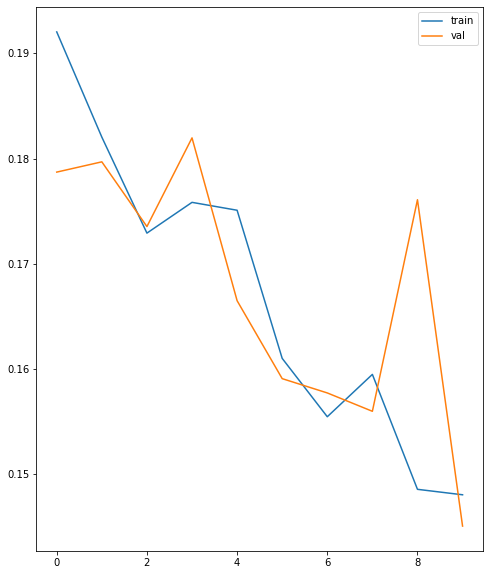

In [9]:
plt.figure(figsize=(8,10))
model.plot_hist()

## Evaluate

In [10]:
import Module.decoder
reload(Module.decoder)
from Module.decoder import GreedyDecoder

outputs, loss = model.eval(val_loader, decoder=GreedyDecoder, out=True)

In [11]:
for batch in val_loader:
    x,y = batch
    for a,b in zip(outputs,y):
        res = dataset.intencode.convert_to_chars(a)
        gt = dataset.intencode.convert_to_chars(b)
        print('pred:',res,' gt:',  gt)
    break

pred: tiii  gt: marvin
pred: iyeyeyyyyyeyyyeyyyyyey  gt: happy
pred: utytqtqttttqtqyyytttt  gt: go
pred: eiyuuuuuuquuyyuuuuu  gt: house
pred: tuuquuuuwuuuueuuqiuuuquuiquq  gt: left
pred: rtttttttttttttttt  gt: nine
pred: wwwwwwwwwwwwtwwwwwwwewwwwww  gt: five
pred: tieiiiiqeeeeiiiiiiiiiiieiii  gt: five
pred: ywwwwwwwwwwwwwwwwwwwwwwwwwww  gt: three
pred: qtttttttt  gt: eight
